

# Project: Analyze Soccer Database  

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

I selected the soccer database from Kaggle. It contains more than 25,000 matches and more than 10,000 players , players and  from several European countries from 2008 to 2016. By means of Exploratory Data Analysis method. Although we won’t be getting into the details of it for our example, the dataset even has attributes on weekly game updates, team line up, and detailed match events.
The goal of this notebook is to walk you through an end to end process of analyzing a dataset . Our simple analytical process will include some steps for exploring and cleaning our dataset.

Question
- we can predict the the winner of match based on this dataset
- we have the history of teams matches and thier players?
- can we identify the team or player belong to the best teams/players ? 

we will make some steps for predicting player performance using basic statistics, and some steps for grouping similar clusters using machine learning.

## Import Libraries

We will start by importing the Python libraries we will be using in this analysis. These libraries include: sqllite3 for interacting with a local relational database pandas and numpy for data ingestion and manipulation matplotlib and seaborn for data visualization specific methods from sklearn for Machine Learning and customplot, which contains custom functions we have written for this notebook

In [40]:


import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import datetime as dt
from scipy import stats
from scipy.stats import norm

<a id='wrangling'></a>
## Data Wrangling



### Ingest Data
Now, we will need to read the dataset using the commands below.

In [5]:
with sqlite3.connect("database.sqlite") as connect:
    countries = pd.read_sql_query("SELECT * from Country", connect)
    matches = pd.read_sql_query("SELECT * from Match", connect)
    leagues = pd.read_sql_query("SELECT * from League", connect)
    teams = pd.read_sql_query("SELECT * from Team", connect)
    player = pd.read_sql_query("SELECT * from Player",connect)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes",connect)
    sequence = pd.read_sql_query("SELECT * from sqlite_sequence",connect)
    team_attributes = pd.read_sql_query("SELECT * from Team_Attributes",connect)

In [41]:
def showtable(df):
    '''
    Returns few key metrics of a dataframe.
    '''
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Analyzing Country table

In [61]:
countries

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [60]:
showtable(countries)

Dataset Shape: (11, 2)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,11,1,1729,4769,3.46
1,name,object,0,11,Belgium,England,France,3.46


## Analyzing Leagues table

In [63]:
leagues

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [62]:
showtable(leagues)

Dataset Shape: (11, 3)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,11,1,1729,4769,3.46
1,country_id,int64,0,11,1,1729,4769,3.46
2,name,object,0,11,Belgium Jupiler League,England Premier League,France Ligue 1,3.46


Data is available only for the european leagues. Note that top 5 leaguesa are: Ligue 1, Bundesliga, Serie A, Premier League and LIGA BBVA

### Merge Leagues and Countries tables

In [21]:
countries_leagues_combined = countries.merge(leagues,left_on="id",right_on="id",how="outer")
countries_leagues_combined.head()

,id,name_x,country_id,name_y
0,1,Belgium,1,Belgium Jupiler League
1,1729,England,1729,England Premier League
2,4769,France,4769,France Ligue 1
3,7809,Germany,7809,Germany 1. Bundesliga
4,10257,Italy,10257,Italy Serie A


In [34]:
countries_leagues_combined.isnull().any()

id            False
name_x        False
country_id    False
name_y        False
dtype: bool

In [22]:
countries_leagues_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11 non-null     int64 
 1   name_x      11 non-null     object
 2   country_id  11 non-null     int64 
 3   name_y      11 non-null     object
dtypes: int64(2), object(2)
memory usage: 440.0+ bytes


In [23]:
countries_leagues_combined

,id,name_x,country_id,name_y
0,1,Belgium,1,Belgium Jupiler League
1,1729,England,1729,England Premier League
2,4769,France,4769,France Ligue 1
3,7809,Germany,7809,Germany 1. Bundesliga
4,10257,Italy,10257,Italy Serie A
5,13274,Netherlands,13274,Netherlands Eredivisie
6,15722,Poland,15722,Poland Ekstraklasa
7,17642,Portugal,17642,Portugal Liga ZON Sagres
8,19694,Scotland,19694,Scotland Premier League
9,21518,Spain,21518,Spain LIGA BBVA


In [64]:
showtable(countries_leagues_combined)

Dataset Shape: (11, 4)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,11,1,1729,4769,3.46
1,name_x,object,0,11,Belgium,England,France,3.46
2,country_id,int64,0,11,1,1729,4769,3.46
3,name_y,object,0,11,Belgium Jupiler League,England Premier League,France Ligue 1,3.46


## Analyzing Team Table

In [67]:
showtable(teams)

Dataset Shape: (299, 5)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,299,1,2,3,8.22
1,team_api_id,int64,0,299,9987,9993,10000,8.22
2,team_fifa_api_id,float64,11,285,673,675,15005,8.15
3,team_long_name,object,0,296,KRC Genk,Beerschot AC,SV Zulte-Waregem,8.20
4,team_short_name,object,0,259,GEN,BAC,ZUL,7.94


In [68]:
teams.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [71]:
teams[teams.loc[:,'team_fifa_api_id'].isnull()].any()

id                   True
team_api_id          True
team_fifa_api_id    False
team_long_name       True
team_short_name      True
dtype: bool

In [75]:
teams = teams.dropna()

In [76]:
showtable(teams)

Dataset Shape: (288, 5)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,288,1,2,3,8.17
1,team_api_id,int64,0,288,9987,9993,10000,8.17
2,team_fifa_api_id,float64,0,285,673,675,15005,8.15
3,team_long_name,object,0,285,KRC Genk,Beerschot AC,SV Zulte-Waregem,8.15
4,team_short_name,object,0,251,GEN,BAC,ZUL,7.90


## Analyzing Player table

In [79]:
player

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154
...,...,...,...,...,...,...,...
11055,11071,26357,Zoumana Camara,2488,1979-04-03 00:00:00,182.88,168
11056,11072,111182,Zsolt Laczko,164680,1986-12-18 00:00:00,182.88,176
11057,11073,36491,Zsolt Low,111191,1979-04-29 00:00:00,180.34,154
11058,11074,35506,Zurab Khizanishvili,47058,1981-10-06 00:00:00,185.42,172


In [77]:
showtable(player)

Dataset Shape: (11060, 7)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,11060,1,2,3,13.43
1,player_api_id,int64,0,11060,505942,155782,162549,13.43
2,player_name,object,0,10848,Aaron Appindangoye,Aaron Cresswell,Aaron Doran,13.39
3,player_fifa_api_id,int64,0,11060,218353,189615,186170,13.43
4,birthday,object,0,5762,1992-02-29 00:00:00,1989-12-15 00:00:00,1991-05-13 00:00:00,12.27
5,height,float64,0,20,182.88,170.18,170.18,3.35
6,weight,int64,0,50,187,146,163,4.78


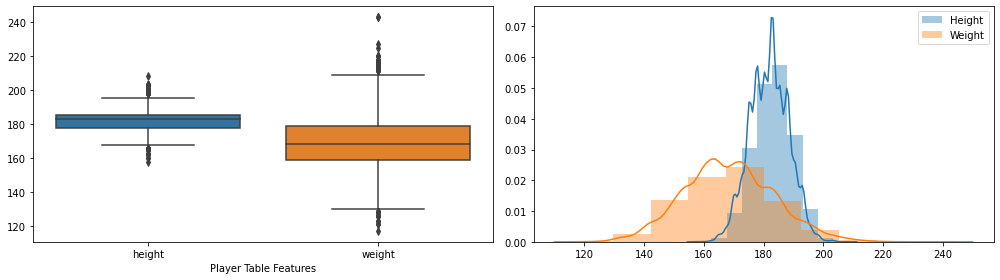

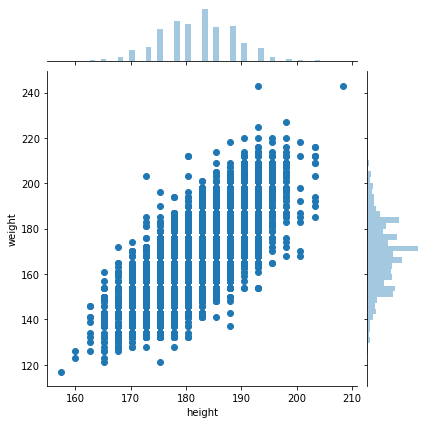

In [78]:
fig1, ax1 = plt.subplots(nrows = 1, ncols = 2)
fig1.set_size_inches(14,4)
sb.boxplot(data = player.loc[:,["height",'weight']], ax = ax1[0])
ax1[0].set_xlabel('Player Table Features')
ax1[0].set_ylabel('')
sb.distplot(a = player.loc[:,["height"]], bins= 10, kde = True, ax = ax1[1], \
            label = 'Height')
sb.distplot(a = player.loc[:,["weight"]], bins= 10, kde = True, ax = ax1[1], \
            label = 'Weight')
ax1[1].legend()
sb.jointplot(x='height',y = 'weight',data = player,kind = 'scatter')
fig1.tight_layout()

For both Hight and Weight feature they follow a normal distribution and follow a linear relationship.

## Analyzing Player Attributes Table

In [80]:
player_attributes

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,183974,102359,39902,2009-08-30 00:00:00,83.0,85.0,right,medium,low,84.0,...,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
183974,183975,102359,39902,2009-02-22 00:00:00,78.0,80.0,right,medium,low,74.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183975,183976,102359,39902,2008-08-30 00:00:00,77.0,80.0,right,medium,low,74.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183976,183977,102359,39902,2007-08-30 00:00:00,78.0,81.0,right,medium,low,74.0,...,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0


In [81]:
showtable(player_attributes)

Dataset Shape: (183978, 42)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,183978,1,2,3,17.49
1,player_fifa_api_id,int64,0,11062,218353,218353,218353,13.19
2,player_api_id,int64,0,11060,505942,505942,505942,13.19
3,date,object,0,197,2016-02-18 00:00:00,2015-11-19 00:00:00,2015-09-21 00:00:00,6.44
4,overall_rating,float64,836,61,67,67,62,4.85
5,potential,float64,836,56,71,71,66,4.76
6,preferred_foot,object,836,2,right,right,right,0.80
7,attacking_work_rate,object,3230,8,medium,medium,medium,1.22
8,defensive_work_rate,object,836,19,medium,medium,medium,1.38
9,crossing,float64,836,95,49,49,49,5.96


In [82]:
player_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

In [83]:
player_attributes.isnull().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

In [84]:
player_attributes.select_dtypes(include =['float64','int64']).head().\
loc[:,player_attributes.select_dtypes(include =['float64','int64']).columns[3:]].head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,62.0,66.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


Analyze the correlation between the features.
We should see a positive correlation between the attacking features, 
and a negative correlation between the attacking and defensive features.

In [85]:
corr_palyer_att = player_attributes.select_dtypes(include =['float64','int64']).\
loc[:,player_attributes.select_dtypes(include =['float64','int64']).columns[3:]]

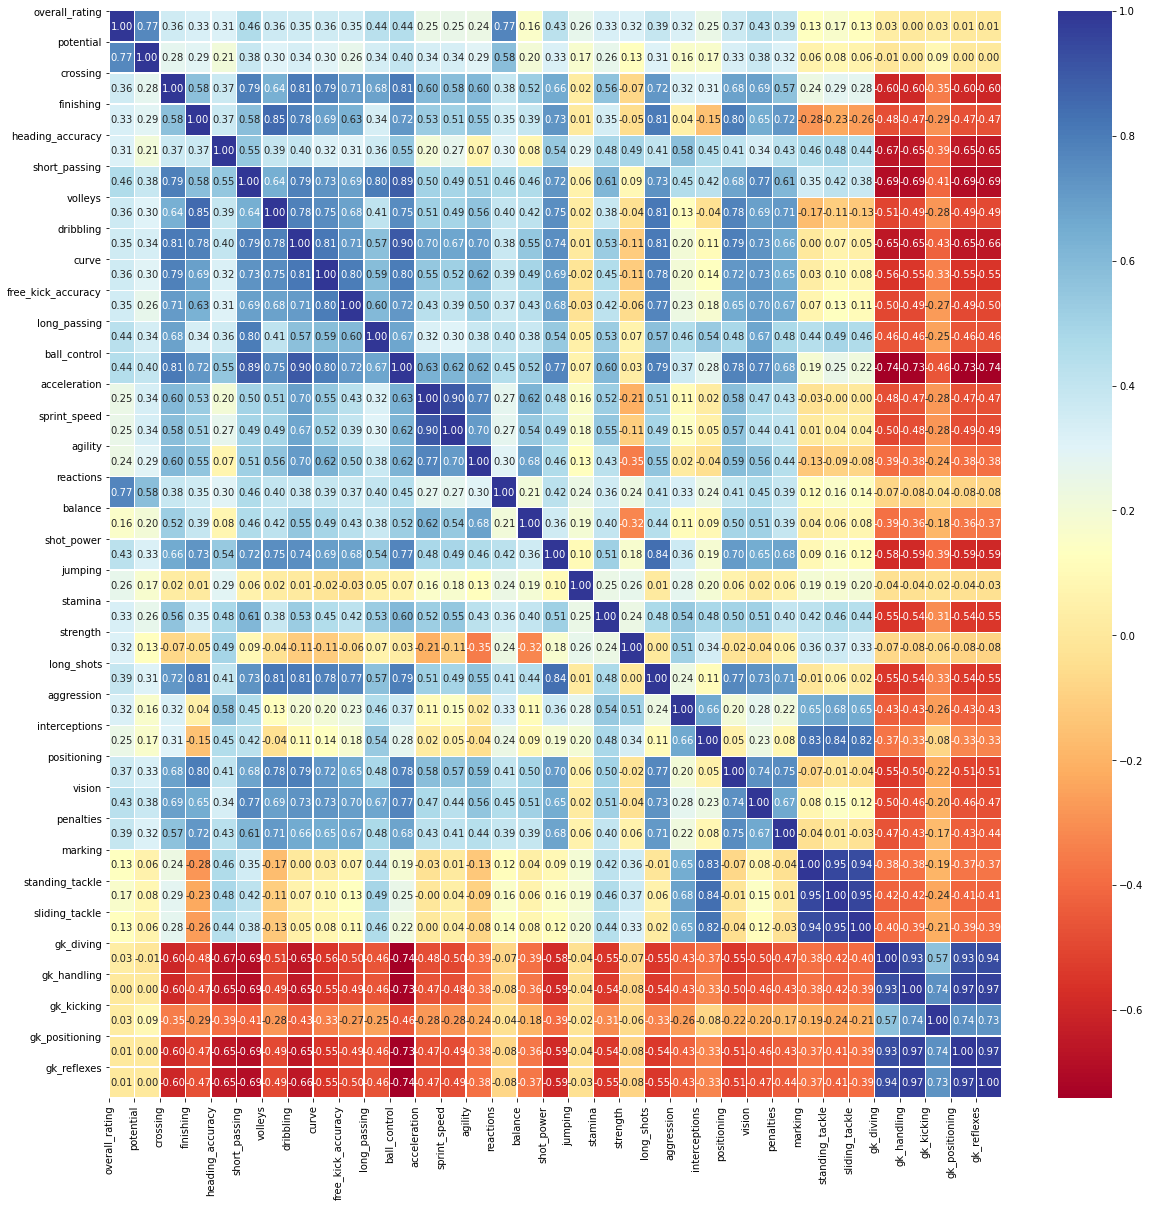

In [293]:
def heatmap(data):
    corr = data.corr()
    fig,ax = plt.subplots(figsize=(20,20))
    sb.heatmap(corr,cmap="RdYlBu",annot=True,fmt=".2f",linewidths=.2)
    plt.xticks(range(len(corr.columns)),corr.columns)
    plt.yticks(range(len(corr.columns)),corr.columns)
    plt.show
heatmap(corr_palyer_att)

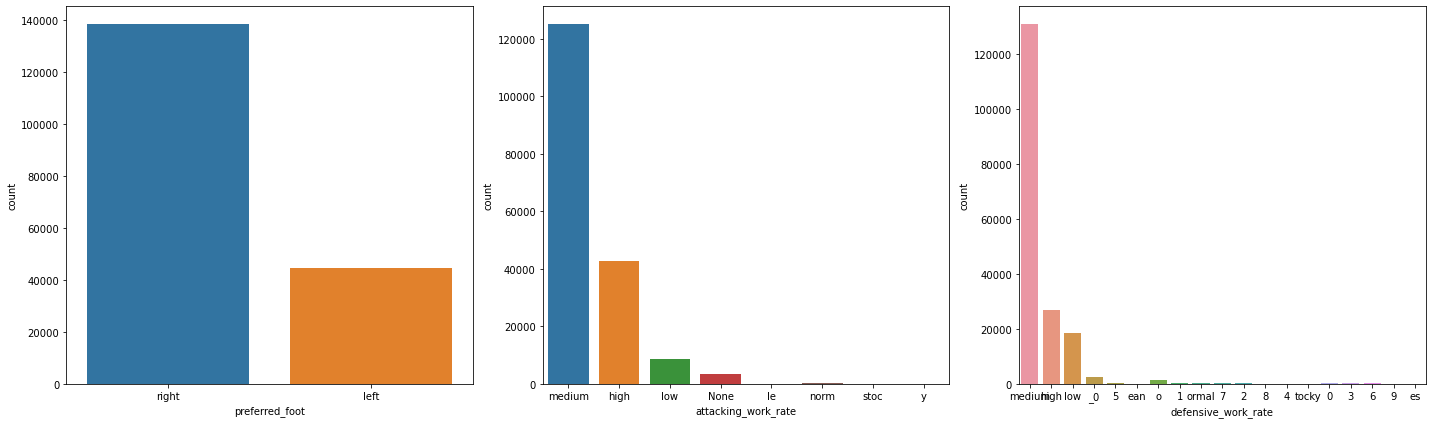

In [292]:
fig2, ax2 = plt.subplots(nrows = 1, ncols = 3)
fig2.set_size_inches(20,6)
sb.countplot(x = player_attributes['preferred_foot'],ax = ax2[0])
sb.countplot(x = player_attributes['attacking_work_rate'],ax = ax2[1])
sb.countplot(x = player_attributes['defensive_work_rate'],ax = ax2[2])
fig2.tight_layout()

In [92]:
print(player_attributes['attacking_work_rate'].value_counts())

medium    125070
high       42823
low         8569
None        3639
norm         348
y            106
le           104
stoc          89
Name: attacking_work_rate, dtype: int64


we will work within medium,low and high value and remove others

In [93]:
print(player_attributes['defensive_work_rate'].value_counts())

medium    130846
high       27041
low        18432
_0          2394
o           1550
1            441
ormal        348
2            342
3            258
5            234
7            217
0            197
6            197
9            152
4            116
es           106
ean          104
tocky         89
8             78
Name: defensive_work_rate, dtype: int64


we will work within medium,low and high value and remove others

In [94]:
print(player_attributes['preferred_foot'].value_counts())

right    138409
left      44733
Name: preferred_foot, dtype: int64


In [97]:
player_attributes_new = player_attributes.loc[(player_attributes['attacking_work_rate'].isin(['medium','high','low']) 
                                            & player_attributes["defensive_work_rate"].isin(["medium","high","low"])),:]

In [98]:
player_attributes_new.shape

(176161, 42)

In [99]:
player_attributes.shape

(183978, 42)

In [101]:
print(player_attributes.shape[0] - player_attributes_new.shape[0], "rows removed" )

7817 rows removed


In [103]:
player_attributes_new.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


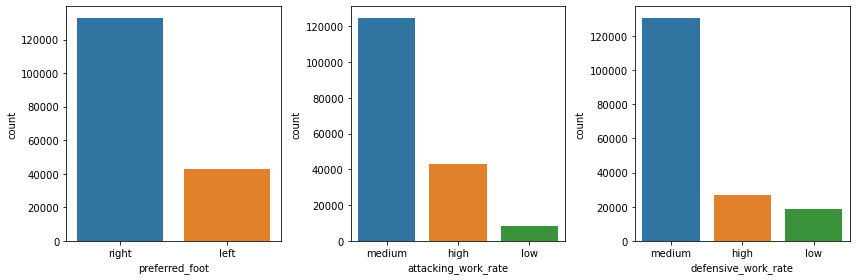

In [111]:
fig3, ax3 = plt.subplots(nrows = 1, ncols = 3)
fig3.set_size_inches(12,4)
sb.countplot(x = player_attributes_new['preferred_foot'],ax = ax3[0])
sb.countplot(x = player_attributes_new['attacking_work_rate'],ax = ax3[1])
sb.countplot(x = player_attributes_new['defensive_work_rate'],ax = ax3[2])
fig3.tight_layout()

In [112]:
showtable(player_attributes_new)

Dataset Shape: (176161, 42)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,176161,1,2,3,17.43
1,player_fifa_api_id,int64,0,9926,218353,218353,218353,13.08
2,player_api_id,int64,0,9925,505942,505942,505942,13.08
3,date,object,0,197,2016-02-18 00:00:00,2015-11-19 00:00:00,2015-09-21 00:00:00,6.49
4,overall_rating,float64,0,61,67,67,62,4.85
5,potential,float64,0,56,71,71,66,4.76
6,preferred_foot,object,0,2,right,right,right,0.80
7,attacking_work_rate,object,0,3,medium,medium,medium,1.06
8,defensive_work_rate,object,0,3,medium,medium,medium,1.07
9,crossing,float64,0,95,49,49,49,5.95


#### We have no nulls lets chick again

In [114]:
player_attributes_new.isnull().sum()

id                     0
player_fifa_api_id     0
player_api_id          0
date                   0
overall_rating         0
potential              0
preferred_foot         0
attacking_work_rate    0
defensive_work_rate    0
crossing               0
finishing              0
heading_accuracy       0
short_passing          0
volleys                0
dribbling              0
curve                  0
free_kick_accuracy     0
long_passing           0
ball_control           0
acceleration           0
sprint_speed           0
agility                0
reactions              0
balance                0
shot_power             0
jumping                0
stamina                0
strength               0
long_shots             0
aggression             0
interceptions          0
positioning            0
vision                 0
penalties              0
marking                0
standing_tackle        0
sliding_tackle         0
gk_diving              0
gk_handling            0
gk_kicking             0


NO NULLS ,
player_attributes_new is clean and ready

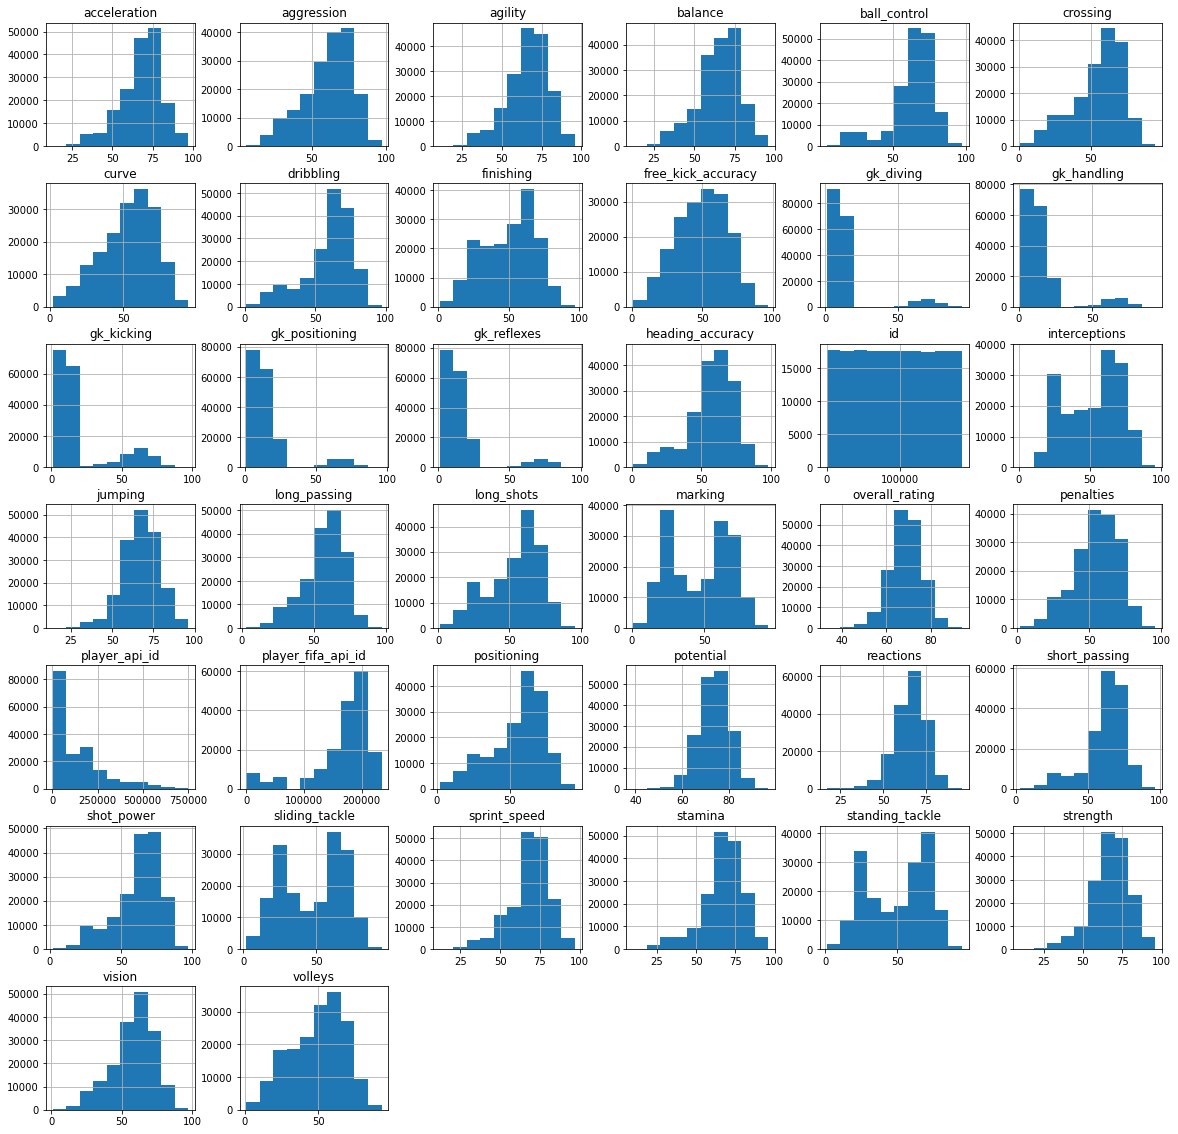

In [118]:
player_attributes_new.hist(figsize=(20,20));

Analyze distribution and spead of continuous features based off of categorical features. Do the levels of each categorical features drastically change the distribution / spead of the continuous features?

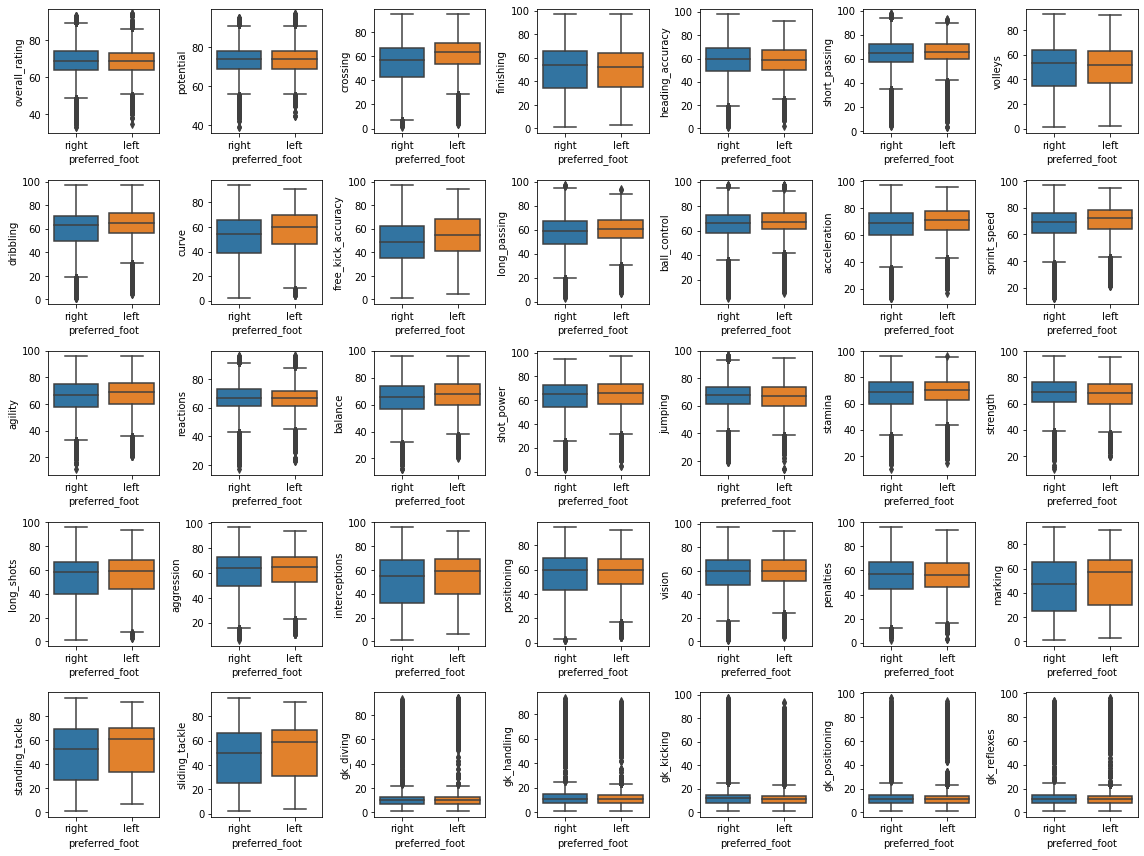

In [121]:
fig4, ax4 = plt.subplots(nrows=5,ncols=7)
fig4.set_size_inches(16,12)
for i,j in enumerate(player_attributes_new.select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
    sb.boxplot(x = "preferred_foot", y = j, data= player_attributes_new, ax = ax4[int(i/7)][i%7])
fig4.tight_layout()

Preferred Foot does not distinguish any of the variables. Distribution of features the same regardless of preferred foot


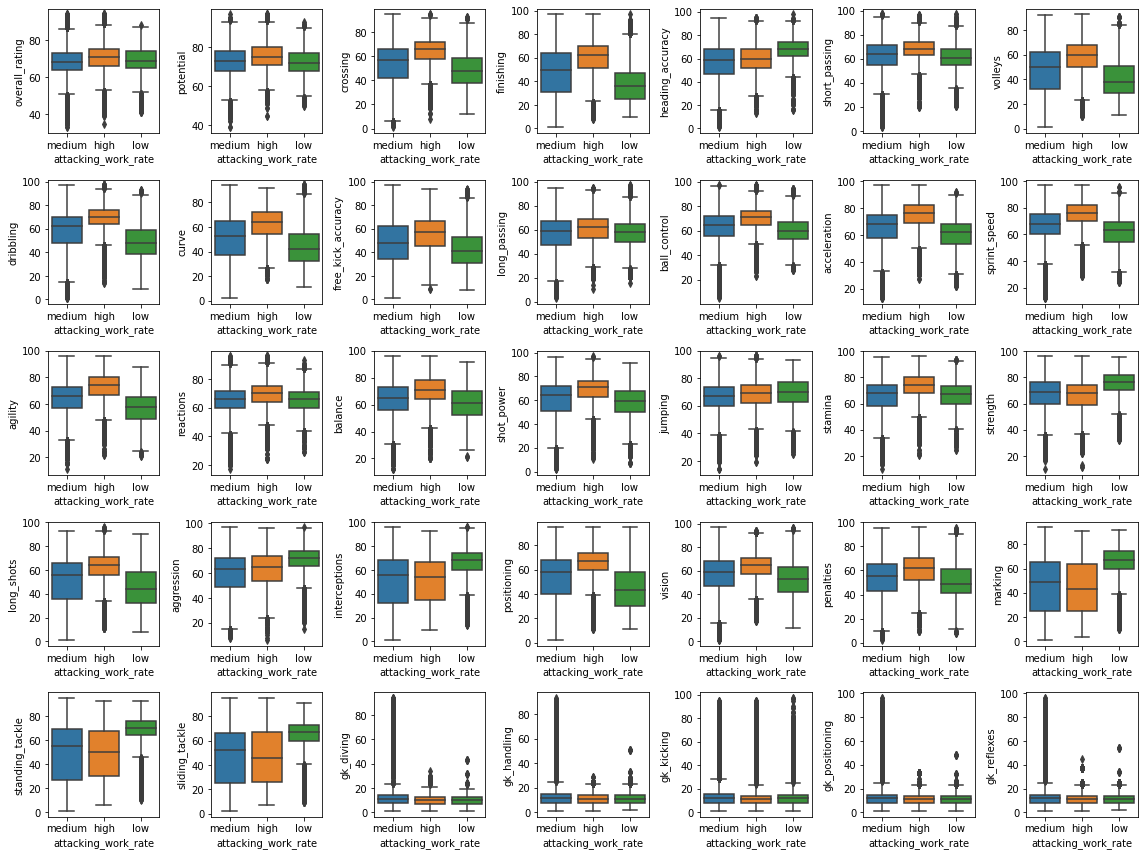

In [122]:
fig4, ax4 = plt.subplots(nrows=5,ncols=7)
fig4.set_size_inches(16,12)
for i,j in enumerate(player_attributes_new.select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
    sb.boxplot(x = "attacking_work_rate", y = j, data= player_attributes_new, ax = ax4[int(i/7)][i%7])
fig4.tight_layout()

Attacking work rate does a better job than "preferred foot" of separating the features but not in a significant manner. 
And also that it does do a decent job of separating instances with high and low attacking work rate. 

## Feature Correlation Analysis

we will check if ‘penalties’ is correlated to ‘overall_rating’. We are using a similar selection operation, bu this time for all the rows and within the correlation function.

In [296]:
player_attributes_new['overall_rating'].corr(df['potential'])

0.1378481869091389

In [297]:
player_attributes_new['overall_rating'].corr(df['reactions'])

0.05579568880108683

In [298]:
corr_feat = player_attributes_new[player_attributes_new.columns[0:]].corr()["overall_rating"][:]

In [299]:
np.abs(corr_feat).sort_values(ascending=False)[1:]

reactions             0.774539
potential             0.764649
short_passing         0.458989
ball_control          0.444013
long_passing          0.434606
vision                0.431398
shot_power            0.428504
long_shots            0.392907
penalties             0.392408
positioning           0.368574
volleys               0.361970
curve                 0.357719
crossing              0.357367
dribbling             0.353778
free_kick_accuracy    0.350082
player_api_id         0.332003
finishing             0.329919
stamina               0.324152
aggression            0.322973
strength              0.315579
heading_accuracy      0.314559
player_fifa_api_id    0.280469
jumping               0.258596
sprint_speed          0.251263
interceptions         0.248702
acceleration          0.242807
agility               0.238806
standing_tackle       0.165308
balance               0.157136
marking               0.132762
sliding_tackle        0.129814
gk_kicking            0.027893
gk_divin

## Data Visualization

we will start plotting the correlation coefficients of each feature with “overall_rating”. We start by selecting the columns and creating a list with correlation coefficients, called “correlations”.

In [300]:
corr_cols = ['reactions',  'potential', 'short_passing', 'ball_control',
       'long_passing', 'vision', 'shot_power', 'long_shots', 'penalties',
       'positioning', 'volleys', 'curve', 'crossing',
       'dribbling', 'free_kick_accuracy', 'player_fifa_api_id', 'finishing', 'stamina', 'aggression',
       'strength', 'heading_accuracy']

### create a list containing correlation between 'overall_rating' with each column in corr_cols

In [302]:
correlations = [ player_attributes_new['overall_rating'].corr(player_attributes_new[f]) for f in corr_cols ]

In [303]:
# create a dataframe using cols and correlations 
player_attributes_new_corr_cols = pd.DataFrame({'attributes': corr_cols, 'correlation': correlations}) 

we will plot a 2D graph of these correlation vealues and column names.

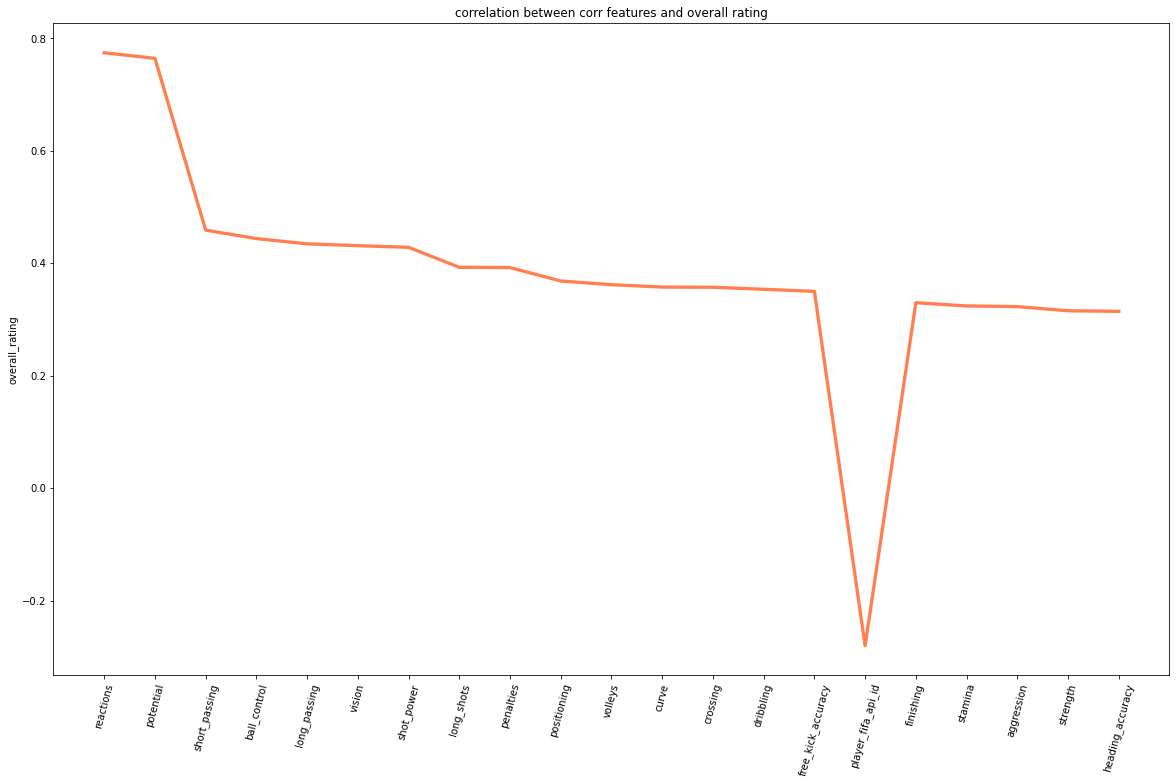

In [307]:
color='coral'
fig7 = plt.gcf()
fig7.set_size_inches(20, 12)
plt.title("correlation between corr features and overall rating")
plt.ylabel("overall_rating")
ax = player_attributes_new_corr_cols.correlation.plot(linewidth=3.3, color=color)
ax.set_xticks(player_attributes_new_corr_cols.index)
ax.set_xticklabels(player_attributes_new_corr_cols.attributes, rotation=75); 

## Analysis of Findings

if we have to predict the player's overall rating ,i will ask for best features of this player ,now lets take the highest 10 features from these features 
What if we took some features and start looking at each player using those features? 
Can we group similar players based on these features? Let’s see how we can do this.

### the highest 10 features

In [309]:
highest_10_feat_corrs = corr_cols[:10]

### Create a new dataframe by selecting the features we just defined

In [312]:
player_attributes_new_feat_selected = player_attributes_new[highest_10_feat_corrs].copy(deep=True)

In [313]:
player_attributes_new_feat_selected.head()

,reactions,potential,short_passing,ball_control,long_passing,vision,shot_power,long_shots,penalties,positioning
0,47.0,71.0,61.0,49.0,64.0,54.0,55.0,35.0,48.0,45.0
1,47.0,71.0,61.0,49.0,64.0,54.0,55.0,35.0,48.0,45.0
2,47.0,66.0,61.0,49.0,64.0,54.0,55.0,35.0,48.0,45.0
3,46.0,65.0,60.0,48.0,63.0,53.0,54.0,34.0,47.0,44.0
4,46.0,65.0,60.0,48.0,63.0,53.0,54.0,34.0,47.0,44.0


In [314]:
player_attributes_new_feat_selected.shape

(176161, 10)

## Machine Learning for prediction

We will use function customplot for kmeans  

In [331]:
#
# First, let us create some utility functions for Plotting
#

def pd_centers(featuresUsed, centers):
    from itertools import cycle, islice
    from pandas.plotting import parallel_coordinates
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    colNames = list(featuresUsed)
    colNames.append('prediction')

    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]

    # Convert to pandas for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

def parallel_plot(data):
    from itertools import cycle, islice
    from pandas.plotting import parallel_coordinates
    import matplotlib.pyplot as plt

    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-2.5,+2.5])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

we will use kmeans to cluster the values (our 10 features) for prediction

In [326]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

In [319]:
# Perform scaling on the dataframe containing the features 
df_ml = scale(player_attributes_new_feat_selected)
num_of_clusters = 5
## Train Model
model = KMeans(init='k-means++', n_clusters=num_of_clusters, n_init=15).fit(df_ml)

In [322]:
print("Players in each cluster")
pd.value_counts(model.labels_, sort=False)

Players in each cluster


0    28363
1    35431
2    36182
3    60533
4    15652
dtype: int64

In [332]:
P_clusters = pd_centers(featuresUsed=highest_10_feat_corrs, centers=model.cluster_centers_)

In [333]:
P_clusters

,reactions,potential,short_passing,ball_control,long_passing,vision,shot_power,long_shots,penalties,positioning,prediction
0,-0.453276,-0.292543,-0.374975,-0.516300,-0.228277,-0.826784,-0.824916,-1.075003,-0.838726,-0.995916,0
1,-0.832571,-0.873823,-0.277619,-0.152441,-0.414088,-0.209081,-0.015688,-0.007510,-0.013742,0.037144,1
2,1.043279,1.042893,0.981498,0.963187,0.896815,1.068996,0.879591,1.005027,0.949181,0.939031,2
3,0.210274,0.112962,0.358871,0.390165,0.278047,0.335145,0.392988,0.387899,0.274409,0.373093,3
4,-0.533157,-0.353576,-2.356951,-2.461970,-1.806131,-1.804717,-2.029126,-1.865793,-1.710786,-1.899397,4


### Visualization of Clusters

- We now have 5 clusters based on the features we selected, we can treat them as profiles for similar groups of players.
- We can visualize these profiles by plotting the centers for each cluster.
- the average values for each featuere within the cluster. 
- We will use matplotlib for this visualization. 

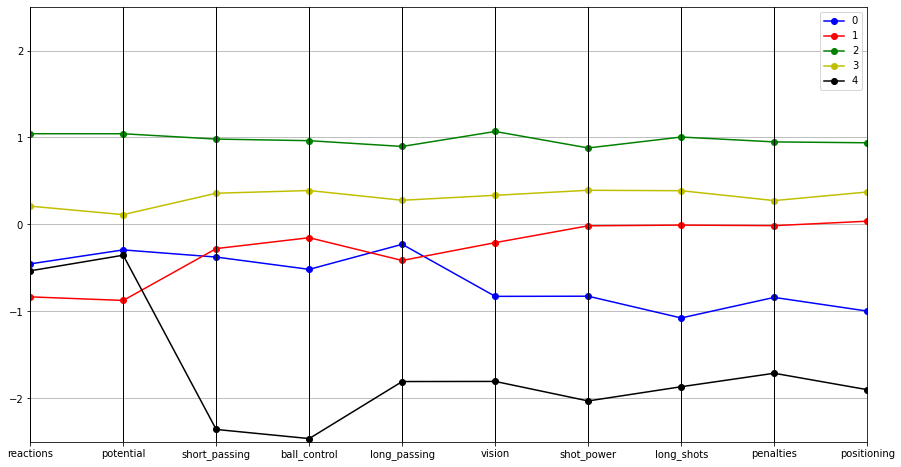

In [334]:
parallel_plot(P_clusters)

## Analyzing Team Attributes Table

In [123]:
showtable(team_attributes)

Dataset Shape: (1458, 25)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,1458,1,2,3,10.51
1,team_fifa_api_id,int64,0,285,434,434,434,8.08
2,team_api_id,int64,0,288,9930,9930,9930,8.09
3,date,object,0,6,2010-02-22 00:00:00,2014-09-19 00:00:00,2015-09-10 00:00:00,2.58
4,buildUpPlaySpeed,int64,0,57,60,52,47,5.25
5,buildUpPlaySpeedClass,object,0,3,Balanced,Balanced,Balanced,0.88
6,buildUpPlayDribbling,float64,969,49,NaN,48,41,5.17
7,buildUpPlayDribblingClass,object,0,3,Little,Normal,Normal,0.98
8,buildUpPlayPassing,int64,0,58,50,56,54,5.19
9,buildUpPlayPassingClass,object,0,3,Mixed,Mixed,Mixed,0.77


#### There are 969 nulls in "buildUpPlayDribbling" feature

the problem is more 60% is missing ,in order to not skew data ,we will drop feature "buildUpPlayDribbling" from dataset and then analyze the rest  

In [9]:
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [124]:
team_attributes_new = team_attributes.drop(['buildUpPlayDribbling'],axis = 1)

In [125]:
showtable(team_attributes_new)

Dataset Shape: (1458, 24)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,1458,1,2,3,10.51
1,team_fifa_api_id,int64,0,285,434,434,434,8.08
2,team_api_id,int64,0,288,9930,9930,9930,8.09
3,date,object,0,6,2010-02-22 00:00:00,2014-09-19 00:00:00,2015-09-10 00:00:00,2.58
4,buildUpPlaySpeed,int64,0,57,60,52,47,5.25
5,buildUpPlaySpeedClass,object,0,3,Balanced,Balanced,Balanced,0.88
6,buildUpPlayDribblingClass,object,0,3,Little,Normal,Normal,0.98
7,buildUpPlayPassing,int64,0,58,50,56,54,5.19
8,buildUpPlayPassingClass,object,0,3,Mixed,Mixed,Mixed,0.77
9,buildUpPlayPositioningClass,object,0,2,Organised,Organised,Organised,0.28


#### There is no missing now

In [127]:
tan = team_attributes_new.loc[:,team_attributes_new.columns.tolist()[3:]]

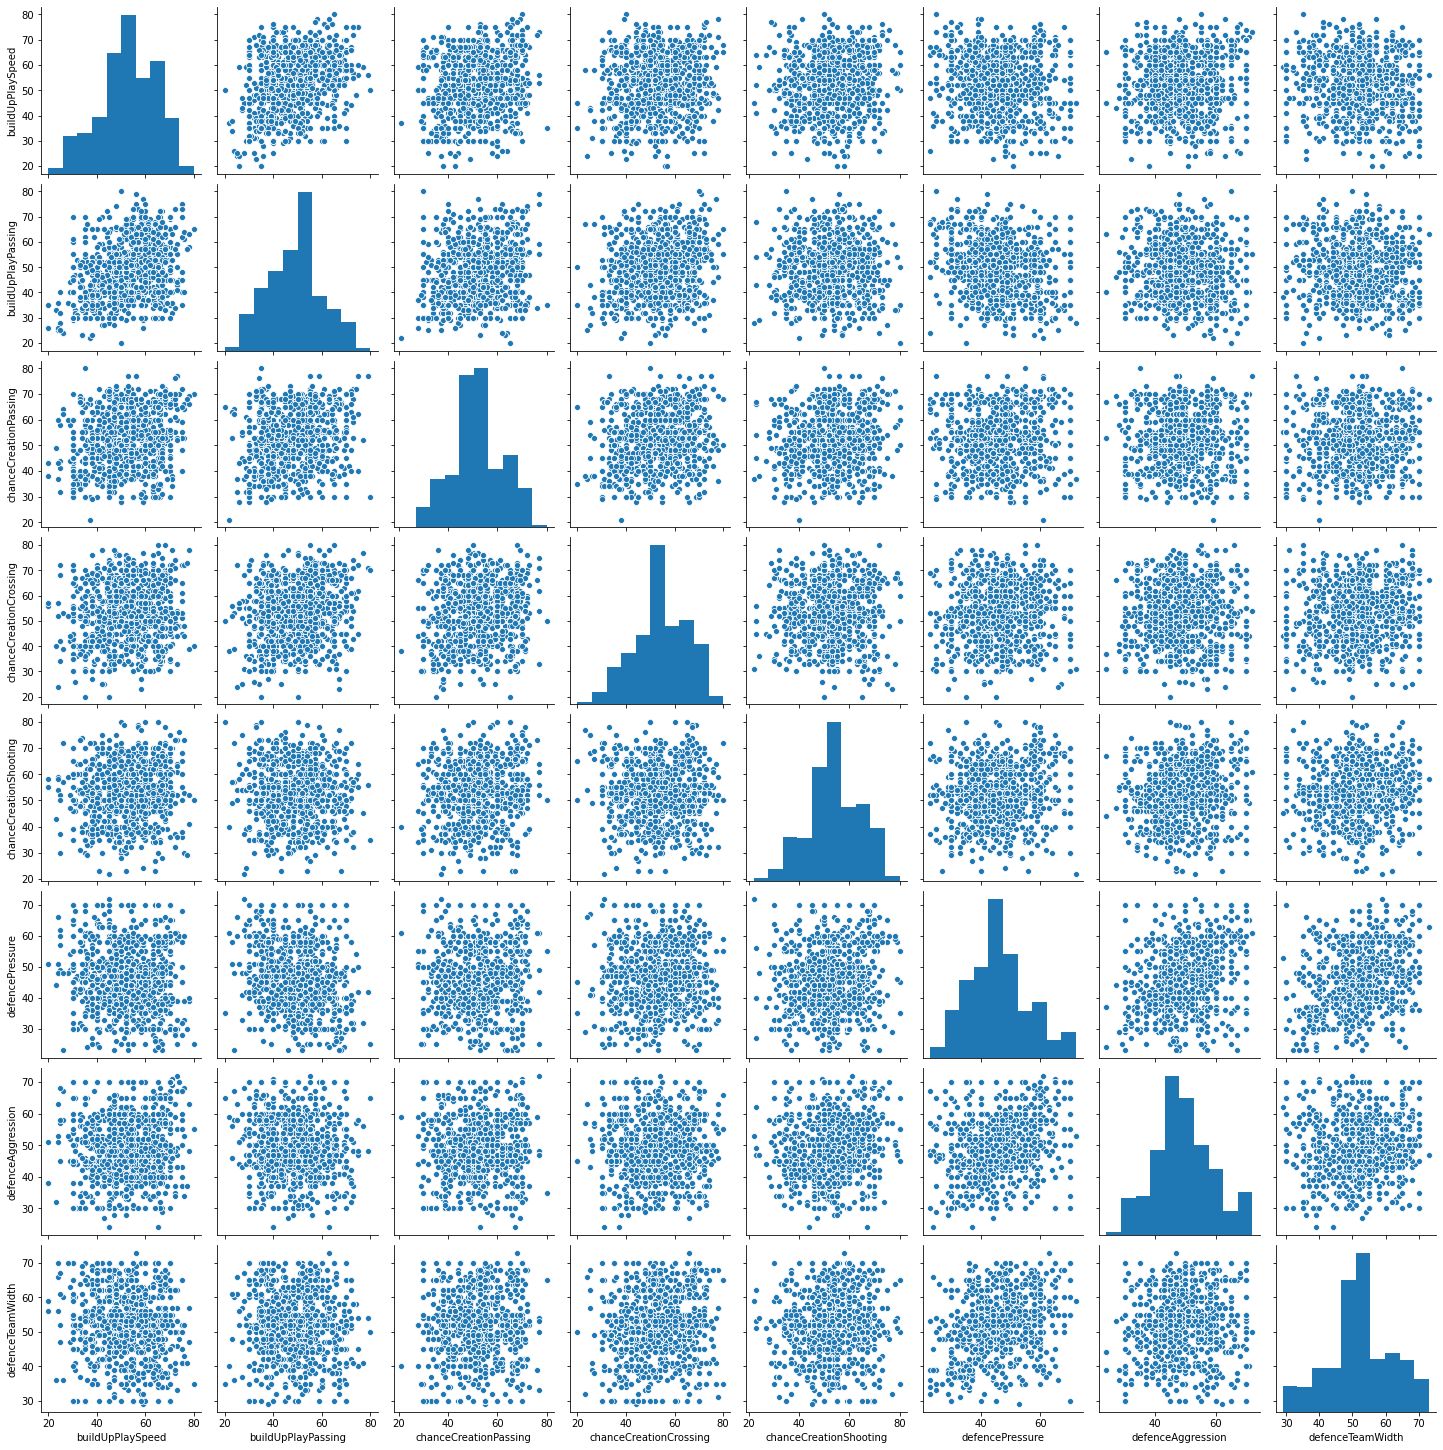

In [129]:
sb.pairplot(tan);

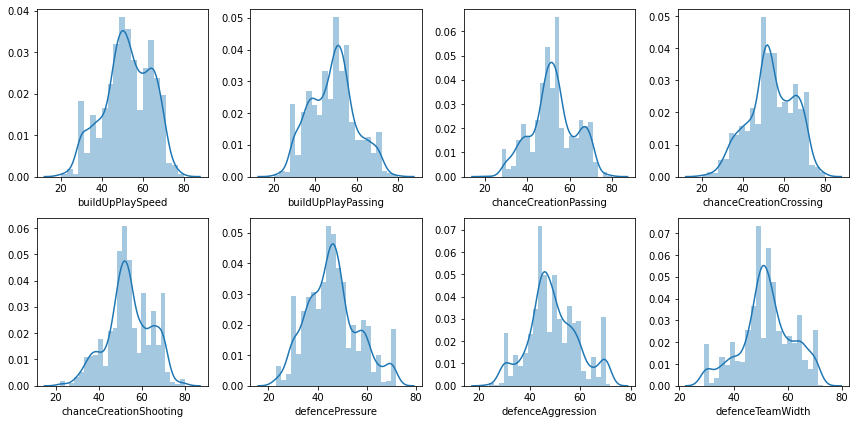

In [135]:
fig5, ax5 = plt.subplots(nrows=2,ncols=4)
fig5.set_size_inches(12,6)
for i,j in enumerate(team_attributes_new.select_dtypes(include = ['int64']).columns[3:].tolist()):
    sb.distplot(tan.loc[:,j],kde =True,hist = True, ax = ax5[int(i/4)][i%4])
fig5.tight_layout()

#### None of them is normally distributed 

#### Select int features (Numerical) to plot it 

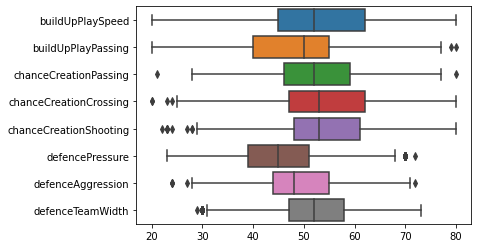

In [137]:
sb.boxplot(data = team_attributes_new.select_dtypes(include = ['int64']).iloc[:,3:],orient = 'h')

#### Plot catogorical features

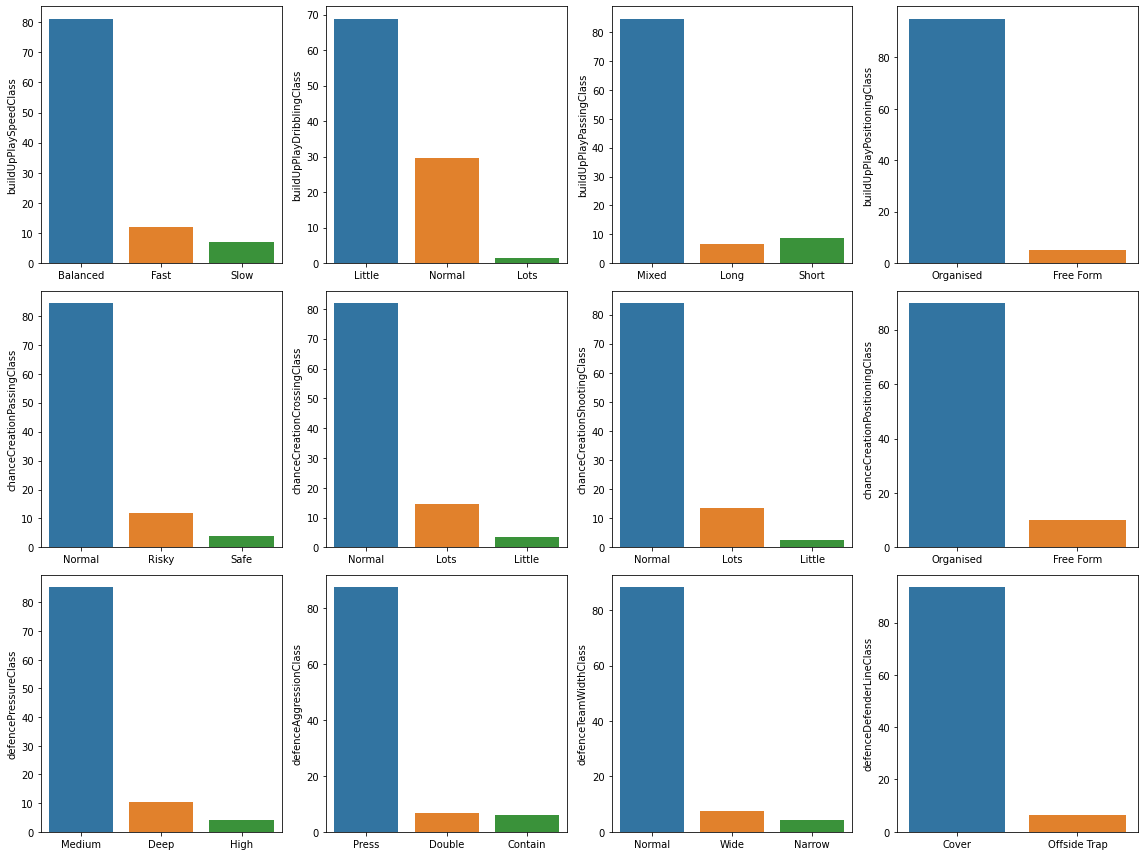

In [139]:
fig6, ax6 = plt.subplots(nrows=3,ncols=4)
fig6.set_size_inches(16,12)
for i,j in enumerate(team_attributes_new.select_dtypes(include = ['object']).columns[1:].tolist()):
    sb.barplot(x = j, y = j, data = tan,estimator = lambda x: len(x)/len(tan) * 100, ax = ax6[int(i/4)][i%4],orient = 'v')
    ax6[int(i/4)][i%4].set(xlabel = "")
fig6.tight_layout()

In [335]:
#sb.pairplot(tan,hue = tan.select_dtypes(include = ['object']).columns.tolist()[12]) 

## Analyzing match table

In [59]:
showtable(matches)

Dataset Shape: (25979, 115)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,25979,1,2,3,14.67
1,country_id,int64,0,11,1,1,1,3.42
2,league_id,int64,0,11,1,1,1,3.42
3,season,object,0,8,2008/2009,2008/2009,2008/2009,3.00
4,stage,int64,0,38,1,1,1,5.23
...,...,...,...,...,...,...,...,...
110,GBD,float64,11817,84,3.25,3.25,3.2,4.26
111,GBA,float64,11817,172,4,3.75,2.5,6.28
112,BSH,float64,11818,101,1.73,1.91,2.3,5.86
113,BSD,float64,11818,59,3.4,3.25,3.2,4.05


In [163]:
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [149]:
BSA_mean = matches["BSA"].mean()

In [156]:
BSD_mean = matches["BSD"].mean()
BSH_mean = matches["BSH"].mean()
GBA_mean = matches["GBA"].mean()
GBD_mean = matches["GBD"].mean()


In [152]:
matches_new = matches

In [154]:
matches_new["BSA"].fillna(BSA_mean,inplace=True)

In [157]:
matches_new["BSD"].fillna(BSD_mean,inplace=True)
matches_new["BSH"].fillna(BSH_mean,inplace=True)
matches_new["GBA"].fillna(GBA_mean,inplace=True)
matches_new["GBD"].fillna(GBD_mean,inplace=True)

In [158]:
showtable(matches_new)

Dataset Shape: (25979, 115)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,25979,1,2,3,14.67
1,country_id,int64,0,11,1,1,1,3.42
2,league_id,int64,0,11,1,1,1,3.42
3,season,object,0,8,2008/2009,2008/2009,2008/2009,3.00
4,stage,int64,0,38,1,1,1,5.23
...,...,...,...,...,...,...,...,...
110,GBD,float64,0,85,3.25,3.25,3.2,3.32
111,GBA,float64,0,173,4,3.75,2.5,4.42
112,BSH,float64,0,102,1.73,1.91,2.3,4.19
113,BSD,float64,0,60,3.4,3.25,3.2,3.20


In [159]:
print("Dimension of Matches Table is: {}".format(matches.shape))
print(100*"*")
print(matches.info())
print(100*"*")
print(matches.select_dtypes(exclude=['float64','int64']).describe())
print(100*"*")
print(matches.describe())
print(100*"*")
print(matches.isnull().sum(axis=0))

Dimension of Matches Table is: (25979, 115)
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB
None
****************************************************************************************************
           season                 date      goal      shoton      shotoff  \
count       25979                25979     14217       14217        14217   
unique          8                 1694     13225        8464         8464   
top     2015/2016  2009-04-11 00:00:00  <goal />  <shoton />  <shotoff />   
freq         3326                   60       993        5754         5754   

            foulcommit      card      cross      corner      possession  
count            14217     14217      14217       14217           14217  
unique            8466     13777       846

True

In [165]:
matches_new_att = matches_new.select_dtypes(include =['float64','int64']).\
loc[:,matches_new.select_dtypes(include =['float64','int64']).columns[3:]]

In [172]:
GBH_mean = matches["GBH"].mean()
VCA_mean = matches["VCA"].mean()
VCD_mean = matches["VCD"].mean()
VCH_mean = matches["VCH"].mean()
SJA_mean = matches["SJA"].mean()
home_player_X1_mean = matches["home_player_X1"].mean()
home_player_X2_mean = matches["home_player_X2"].mean()
home_player_X3_mean = matches["home_player_X3"].mean()
home_player_X4_mean = matches["home_player_X4"].mean()

In [173]:
matches_new["GBH"].fillna(GBH_mean,inplace=True)
matches_new["VCA"].fillna(VCA_mean,inplace=True)
matches_new["VCD"].fillna(VCD_mean,inplace=True)
matches_new["VCH"].fillna(VCH_mean,inplace=True)
matches_new["SJA"].fillna(SJA_mean,inplace=True)
matches_new["home_player_X1"].fillna(home_player_X1_mean,inplace=True)
matches_new["home_player_X2"].fillna(home_player_X2_mean,inplace=True)
matches_new["home_player_X3"].fillna(home_player_X3_mean,inplace=True)
matches_new["home_player_X4"].fillna(home_player_X4_mean,inplace=True)

In [192]:
matches_new_att = matches_new.isnull().any()

In [188]:
types = matches.dtypes

In [336]:
# Check for nulls values in matches table

In [193]:
print(matches_new_att[:50])

id                  False
country_id          False
league_id           False
season              False
stage               False
date                False
match_api_id        False
home_team_api_id    False
away_team_api_id    False
home_team_goal      False
away_team_goal      False
home_player_X1      False
home_player_X2      False
home_player_X3      False
home_player_X4      False
home_player_X5       True
home_player_X6       True
home_player_X7       True
home_player_X8       True
home_player_X9       True
home_player_X10      True
home_player_X11      True
away_player_X1       True
away_player_X2       True
away_player_X3       True
away_player_X4       True
away_player_X5       True
away_player_X6       True
away_player_X7       True
away_player_X8       True
away_player_X9       True
away_player_X10      True
away_player_X11      True
home_player_Y1       True
home_player_Y2       True
home_player_Y3       True
home_player_Y4       True
home_player_Y5       True
home_player_

In [207]:
matches_new.fillna(matches_new.mean(),inplace=True)

In [211]:
m1 = matches_new.isnull().sum()

In [214]:
print(m1[60:])

home_player_6         0
home_player_7         0
home_player_8         0
home_player_9         0
home_player_10        0
home_player_11        0
away_player_1         0
away_player_2         0
away_player_3         0
away_player_4         0
away_player_5         0
away_player_6         0
away_player_7         0
away_player_8         0
away_player_9         0
away_player_10        0
away_player_11        0
goal              11762
shoton            11762
shotoff           11762
foulcommit        11762
card              11762
cross             11762
corner            11762
possession        11762
B365H                 0
B365D                 0
B365A                 0
BWH                   0
BWD                   0
BWA                   0
IWH                   0
IWD                   0
IWA                   0
LBH                   0
LBD                   0
LBA                   0
PSH                   0
PSD                   0
PSA                   0
WHH                   0
WHD             

In [208]:
matches_new.isnull().sum().any()

True

### I do not know to fill what in these nulls ,so i'll drop these featues,and nulls are 11762 until if it numeriacl ,i will drop them because about 44% of this feature are missing

In [229]:
matches_new.drop(['goal','shoton','shotoff','foulcommit','card','cross','corner','possession'],axis=1,inplace=True)

In [223]:
matches_new['goal'].describe()

count        14217
unique       13225
top       <goal />
freq           993
Name: goal, dtype: object

In [222]:
showtable(matches_new)

Dataset Shape: (25979, 115)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,25979,1,2,3,14.67
1,country_id,int64,0,11,1,1,1,3.42
2,league_id,int64,0,11,1,1,1,3.42
3,season,object,0,8,2008/2009,2008/2009,2008/2009,3.00
4,stage,int64,0,38,1,1,1,5.23
...,...,...,...,...,...,...,...,...
110,GBD,float64,0,85,3.25,3.25,3.2,3.32
111,GBA,float64,0,173,4,3.75,2.5,4.42
112,BSH,float64,0,102,1.73,1.91,2.3,4.19
113,BSD,float64,0,60,3.4,3.25,3.2,3.20


In [230]:
matches_new.isnull().sum().any()

False

# Finally, there is no nulls in Matches table

## we will combine all tables together

In [232]:
countries_leagues_combined.head()

,id,name_x,country_id,name_y
0,1,Belgium,1,Belgium Jupiler League
1,1729,England,1729,England Premier League
2,4769,France,4769,France Ligue 1
3,7809,Germany,7809,Germany 1. Bundesliga
4,10257,Italy,10257,Italy Serie A


In [245]:
teams[teams["id"] == "50201"]

C:\Users\Ahmad Abd Elhameed\Anaconda3\envs\deep\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name


In [247]:
q = teams
w = countries_leagues_combined

In [248]:
e= q.merge(w,left_on="id",right_on="id",how="outer")

In [249]:
e

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name,name_x,country_id,name_y
0,1,9987.0,673.0,KRC Genk,GEN,Belgium,1.0,Belgium Jupiler League
1,2,9993.0,675.0,Beerschot AC,BAC,NaN,NaN,NaN
2,3,10000.0,15005.0,SV Zulte-Waregem,ZUL,NaN,NaN,NaN
3,4,9994.0,2007.0,Sporting Lokeren,LOK,NaN,NaN,NaN
4,5,9984.0,1750.0,KSV Cercle Brugge,CEB,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
293,15722,NaN,NaN,NaN,NaN,Poland,15722.0,Poland Ekstraklasa
294,17642,NaN,NaN,NaN,NaN,Portugal,17642.0,Portugal Liga ZON Sagres
295,19694,NaN,NaN,NaN,NaN,Scotland,19694.0,Scotland Premier League
296,21518,NaN,NaN,NaN,NaN,Spain,21518.0,Spain LIGA BBVA


In [252]:
q

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB
...,...,...,...,...,...
293,49124,10243,894.0,FC Zürich,ZUR
294,49479,10190,898.0,FC St. Gallen,GAL
295,49837,10191,1715.0,FC Thun,THU
296,50201,9777,324.0,Servette FC,SER


In [253]:
w

,id,name_x,country_id,name_y
0,1,Belgium,1,Belgium Jupiler League
1,1729,England,1729,England Premier League
2,4769,France,4769,France Ligue 1
3,7809,Germany,7809,Germany 1. Bundesliga
4,10257,Italy,10257,Italy Serie A
5,13274,Netherlands,13274,Netherlands Eredivisie
6,15722,Poland,15722,Poland Ekstraklasa
7,17642,Portugal,17642,Portugal Liga ZON Sagres
8,19694,Scotland,19694,Scotland Premier League
9,21518,Spain,21518,Spain LIGA BBVA


In [254]:
r = team_attributes_new
t = player
y = player_attributes_new
u = matches_new

In [255]:
d= e.merge(r,left_on="id",right_on="id",how="outer")

In [256]:
d

,id,team_api_id_x,team_fifa_api_id_x,team_long_name,team_short_name,name_x,country_id,name_y,team_fifa_api_id_y,team_api_id_y,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,9987.0,673.0,KRC Genk,GEN,Belgium,1.0,Belgium Jupiler League,434.0,9930.0,...,55.0,Normal,Organised,50.0,Medium,55.0,Press,45.0,Normal,Cover
1,2,9993.0,675.0,Beerschot AC,BAC,NaN,NaN,NaN,434.0,9930.0,...,64.0,Normal,Organised,47.0,Medium,44.0,Press,54.0,Normal,Cover
2,3,10000.0,15005.0,SV Zulte-Waregem,ZUL,NaN,NaN,NaN,434.0,9930.0,...,64.0,Normal,Organised,47.0,Medium,44.0,Press,54.0,Normal,Cover
3,4,9994.0,2007.0,Sporting Lokeren,LOK,NaN,NaN,NaN,77.0,8485.0,...,70.0,Lots,Organised,60.0,Medium,70.0,Double,70.0,Wide,Cover
4,5,9984.0,1750.0,KSV Cercle Brugge,CEB,NaN,NaN,NaN,77.0,8485.0,...,52.0,Normal,Organised,47.0,Medium,47.0,Press,52.0,Normal,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15005.0,10000.0,...,53.0,Normal,Organised,46.0,Medium,48.0,Press,53.0,Normal,Cover
1733,1455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15005.0,10000.0,...,50.0,Normal,Organised,44.0,Medium,55.0,Press,53.0,Normal,Cover
1734,1456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15005.0,10000.0,...,32.0,Little,Organised,44.0,Medium,58.0,Press,37.0,Normal,Cover
1735,1457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15005.0,10000.0,...,32.0,Little,Organised,44.0,Medium,58.0,Press,37.0,Normal,Cover


In [257]:
f = d.merge(t,left_on="id",right_on="id",how="outer")
f

,id,team_api_id_x,team_fifa_api_id_x,team_long_name,team_short_name,name_x,country_id,name_y,team_fifa_api_id_y,team_api_id_y,...,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,9987.0,673.0,KRC Genk,GEN,Belgium,1.0,Belgium Jupiler League,434.0,9930.0,...,Press,45.0,Normal,Cover,505942.0,Aaron Appindangoye,218353.0,1992-02-29 00:00:00,182.88,187.0
1,2,9993.0,675.0,Beerschot AC,BAC,NaN,NaN,NaN,434.0,9930.0,...,Press,54.0,Normal,Cover,155782.0,Aaron Cresswell,189615.0,1989-12-15 00:00:00,170.18,146.0
2,3,10000.0,15005.0,SV Zulte-Waregem,ZUL,NaN,NaN,NaN,434.0,9930.0,...,Press,54.0,Normal,Cover,162549.0,Aaron Doran,186170.0,1991-05-13 00:00:00,170.18,163.0
3,4,9994.0,2007.0,Sporting Lokeren,LOK,NaN,NaN,NaN,77.0,8485.0,...,Double,70.0,Wide,Cover,30572.0,Aaron Galindo,140161.0,1982-05-08 00:00:00,182.88,198.0
4,5,9984.0,1750.0,KSV Cercle Brugge,CEB,NaN,NaN,NaN,77.0,8485.0,...,Press,52.0,Normal,Cover,23780.0,Aaron Hughes,17725.0,1979-11-08 00:00:00,182.88,154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11270,11070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,282473.0,Zouhair Feddal,205705.0,1989-01-01 00:00:00,190.50,172.0
11271,11071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,26357.0,Zoumana Camara,2488.0,1979-04-03 00:00:00,182.88,168.0
11272,11072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,111182.0,Zsolt Laczko,164680.0,1986-12-18 00:00:00,182.88,176.0
11273,11073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,36491.0,Zsolt Low,111191.0,1979-04-29 00:00:00,180.34,154.0


In [258]:
g = f.merge(y,left_on="id",right_on="id",how="outer")

In [259]:
g

,id,team_api_id_x,team_fifa_api_id_x,team_long_name,team_short_name,name_x,country_id,name_y,team_fifa_api_id_y,team_api_id_y,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,9987.0,673.0,KRC Genk,GEN,Belgium,1.0,Belgium Jupiler League,434.0,9930.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,9993.0,675.0,Beerschot AC,BAC,NaN,NaN,NaN,434.0,9930.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,10000.0,15005.0,SV Zulte-Waregem,ZUL,NaN,NaN,NaN,434.0,9930.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,9994.0,2007.0,Sporting Lokeren,LOK,NaN,NaN,NaN,77.0,8485.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,9984.0,1750.0,KSV Cercle Brugge,CEB,NaN,NaN,NaN,77.0,8485.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176505,183974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
176506,183975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
176507,183976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
176508,183977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0


In [265]:
h = g.merge(u,left_on="id",right_on="id",how="outer")
h

,id,team_api_id_x,team_fifa_api_id_x,team_long_name,team_short_name,name_x,country_id_x,name_y,team_fifa_api_id_y,team_api_id_y,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,9987.0,673.0,KRC Genk,GEN,Belgium,1.0,Belgium Jupiler League,434.0,9930.0,...,4.000000,1.650000,3.400000,4.500000,1.780000,3.250000,4.000000,1.730000,3.400000,4.200000
1,2,9993.0,675.0,Beerschot AC,BAC,NaN,NaN,NaN,434.0,9930.0,...,3.800000,2.000000,3.250000,3.250000,1.850000,3.250000,3.750000,1.910000,3.250000,3.600000
2,3,10000.0,15005.0,SV Zulte-Waregem,ZUL,NaN,NaN,NaN,434.0,9930.0,...,2.500000,2.350000,3.250000,2.650000,2.500000,3.200000,2.500000,2.300000,3.200000,2.750000
3,4,9994.0,2007.0,Sporting Lokeren,LOK,NaN,NaN,NaN,77.0,8485.0,...,7.500000,1.450000,3.750000,6.500000,1.500000,3.750000,5.500000,1.440000,3.750000,6.500000
4,5,9984.0,1750.0,KSV Cercle Brugge,CEB,NaN,NaN,NaN,77.0,8485.0,...,1.730000,4.500000,3.400000,1.650000,4.500000,3.500000,1.650000,4.750000,3.300000,1.670000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177169,25876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.622343,2.668107,3.899048,4.840281,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663
177170,25877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.622343,2.668107,3.899048,4.840281,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663
177171,25878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.622343,2.668107,3.899048,4.840281,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663
177172,25879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.622343,2.668107,3.899048,4.840281,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663


In [266]:
showtable(h)

Dataset Shape: (177174, 184)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,177174,1,2,3,17.43
1,team_api_id_x,float64,176886,288,9987,9993,10000,8.17
2,team_fifa_api_id_x,float64,176886,285,673,675,15005,8.15
3,team_long_name,object,176886,285,KRC Genk,Beerschot AC,SV Zulte-Waregem,8.15
4,team_short_name,object,176886,251,GEN,BAC,ZUL,7.90
...,...,...,...,...,...,...,...,...
179,GBD,float64,151195,85,3.25,3.25,3.2,3.32
180,GBA,float64,151195,173,4,3.75,2.5,4.42
181,BSH,float64,151195,102,1.73,1.91,2.3,4.19
182,BSD,float64,151195,60,3.4,3.25,3.2,3.20


In [267]:
h.drop(["team_api_id_x",'team_fifa_api_id_x',"team_long_name","team_short_name","name_x","country_id_x","name_y","team_fifa_api_id_y","team_api_id_y"],axis=1,inplace=True)

In [268]:
showtable(h)

Dataset Shape: (177174, 175)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,177174,1,2,3,17.43
1,date_x,object,175716,6,2010-02-22 00:00:00,2014-09-19 00:00:00,2015-09-10 00:00:00,2.58
2,buildUpPlaySpeed,float64,175716,57,60,52,47,5.25
3,buildUpPlaySpeedClass,object,175716,3,Balanced,Balanced,Balanced,0.88
4,buildUpPlayDribblingClass,object,175716,3,Little,Normal,Normal,0.98
...,...,...,...,...,...,...,...,...
170,GBD,float64,151195,85,3.25,3.25,3.2,3.32
171,GBA,float64,151195,173,4,3.75,2.5,4.42
172,BSH,float64,151195,102,1.73,1.91,2.3,4.19
173,BSD,float64,151195,60,3.4,3.25,3.2,3.20


In [270]:
h

,id,date_x,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,2010-02-22 00:00:00,60.0,Balanced,Little,50.0,Mixed,Organised,60.0,Normal,...,4.000000,1.650000,3.400000,4.500000,1.780000,3.250000,4.000000,1.730000,3.400000,4.200000
1,2,2014-09-19 00:00:00,52.0,Balanced,Normal,56.0,Mixed,Organised,54.0,Normal,...,3.800000,2.000000,3.250000,3.250000,1.850000,3.250000,3.750000,1.910000,3.250000,3.600000
2,3,2015-09-10 00:00:00,47.0,Balanced,Normal,54.0,Mixed,Organised,54.0,Normal,...,2.500000,2.350000,3.250000,2.650000,2.500000,3.200000,2.500000,2.300000,3.200000,2.750000
3,4,2010-02-22 00:00:00,70.0,Fast,Little,70.0,Long,Organised,70.0,Risky,...,7.500000,1.450000,3.750000,6.500000,1.500000,3.750000,5.500000,1.440000,3.750000,6.500000
4,5,2011-02-22 00:00:00,47.0,Balanced,Little,52.0,Mixed,Organised,53.0,Normal,...,1.730000,4.500000,3.400000,1.650000,4.500000,3.500000,1.650000,4.750000,3.300000,1.670000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177169,25876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.622343,2.668107,3.899048,4.840281,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663
177170,25877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.622343,2.668107,3.899048,4.840281,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663
177171,25878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.622343,2.668107,3.899048,4.840281,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663
177172,25879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.622343,2.668107,3.899048,4.840281,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663


In [276]:
j = h.isnull().sum()

In [278]:
print(j[40:80])

volleys                 1013
dribbling               1013
curve                   1013
free_kick_accuracy      1013
long_passing            1013
ball_control            1013
acceleration            1013
sprint_speed            1013
agility                 1013
reactions               1013
balance                 1013
shot_power              1013
jumping                 1013
stamina                 1013
strength                1013
long_shots              1013
aggression              1013
interceptions           1013
positioning             1013
vision                  1013
penalties               1013
marking                 1013
standing_tackle         1013
sliding_tackle          1013
gk_diving               1013
gk_handling             1013
gk_kicking              1013
gk_positioning          1013
gk_reflexes             1013
country_id_y          151195
league_id             151195
season                151195
stage                 151195
date                  151195
match_api_id  

In [271]:
df = h[h["BSA"].notnull()]

In [272]:
showtable(df)

Dataset Shape: (25979, 175)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,25979,1,2,3,14.67
1,date_x,object,24521,6,2010-02-22 00:00:00,2014-09-19 00:00:00,2015-09-10 00:00:00,2.58
2,buildUpPlaySpeed,float64,24521,57,60,52,47,5.25
3,buildUpPlaySpeedClass,object,24521,3,Balanced,Balanced,Balanced,0.88
4,buildUpPlayDribblingClass,object,24521,3,Little,Normal,Normal,0.98
...,...,...,...,...,...,...,...,...
170,GBD,float64,0,85,3.25,3.25,3.2,3.32
171,GBA,float64,0,173,4,3.75,2.5,4.42
172,BSH,float64,0,102,1.73,1.91,2.3,4.19
173,BSD,float64,0,60,3.4,3.25,3.2,3.20


In [279]:
df.dropna(inplace=True)

C:\Users\Ahmad Abd Elhameed\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [280]:
df

,id,date_x,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,2010-02-22 00:00:00,60.0,Balanced,Little,50.0,Mixed,Organised,60.0,Normal,...,4.00,1.65,3.40,4.50,1.780000,3.250000,4.000000,1.730000,3.400000,4.200000
1,2,2014-09-19 00:00:00,52.0,Balanced,Normal,56.0,Mixed,Organised,54.0,Normal,...,3.80,2.00,3.25,3.25,1.850000,3.250000,3.750000,1.910000,3.250000,3.600000
2,3,2015-09-10 00:00:00,47.0,Balanced,Normal,54.0,Mixed,Organised,54.0,Normal,...,2.50,2.35,3.25,2.65,2.500000,3.200000,2.500000,2.300000,3.200000,2.750000
3,4,2010-02-22 00:00:00,70.0,Fast,Little,70.0,Long,Organised,70.0,Risky,...,7.50,1.45,3.75,6.50,1.500000,3.750000,5.500000,1.440000,3.750000,6.500000
4,5,2011-02-22 00:00:00,47.0,Balanced,Little,52.0,Mixed,Organised,53.0,Normal,...,1.73,4.50,3.40,1.65,4.500000,3.500000,1.650000,4.750000,3.300000,1.670000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,1454,2011-02-22 00:00:00,52.0,Balanced,Little,52.0,Mixed,Organised,52.0,Normal,...,1.83,4.20,3.50,1.91,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663
1733,1455,2012-02-22 00:00:00,54.0,Balanced,Little,51.0,Mixed,Organised,47.0,Normal,...,2.63,2.55,3.30,2.80,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663
1734,1456,2013-09-20 00:00:00,54.0,Balanced,Little,51.0,Mixed,Organised,47.0,Normal,...,2.10,3.50,3.40,2.15,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663
1735,1457,2014-09-19 00:00:00,54.0,Balanced,Normal,51.0,Mixed,Organised,47.0,Normal,...,2.80,2.30,3.50,3.00,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663


In [281]:
showtable(df)

Dataset Shape: (1365, 175)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,1365,1,2,3,10.41
1,date_x,object,0,6,2010-02-22 00:00:00,2014-09-19 00:00:00,2015-09-10 00:00:00,2.58
2,buildUpPlaySpeed,float64,0,57,60,52,47,5.26
3,buildUpPlaySpeedClass,object,0,3,Balanced,Balanced,Balanced,0.89
4,buildUpPlayDribblingClass,object,0,3,Little,Normal,Normal,0.97
...,...,...,...,...,...,...,...,...
170,GBD,float64,0,33,3.25,3.25,3.2,3.72
171,GBA,float64,0,92,4,3.75,2.5,5.65
172,BSH,float64,0,69,1.73,1.91,2.3,5.38
173,BSD,float64,0,22,3.4,3.25,3.2,3.60


### Now we have clean dataset to use it with machine learning algorithm to predict what you want like the winning of match 

In [282]:
df.isnull().sum().any()

False

<a id='eda'></a>

### Research Question 1 

at the end when megre all tables there will be cells have nulls ?

yes ,due to different shapes of tables

### Research Question 2 

when merged ,it will affect in prediction ?

I think it is ,and we should select algorithm to work well with that dataset

<a id='conclusions'></a>
## Conclusions

Analyzing the league, country, player, player attributes, team, team atributes nad match tables gave a better understanding of the data. 
once features are meerged pass it to machine learning algorithm to predict the winner of the future match. 

We use player attributes table to groups/cluster the players based on its skills like "passing","long pass" etc,to identify which player belong to this group.

And we can use any table and make our predction on it ,I selected the player attributes to make my own

### References

https://github.com/words-sdsc/edX/blob/master/customplot.py